# Dense Neural Network Model

Reloading Tuner from tuning/gbpusd_prediction/tuner0.json
Starting hyperparameter search...

Optimal hyperparameters:
- Number of layers: 4
- Learning rate: 0.00581

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2347 - mae: 1.2347 - val_loss: 0.7271 - val_mae: 0.7271
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6166 - mae: 0.6166 - val_loss: 0.1688 - val_mae: 0.1688
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3884 - mae: 0.3884 - val_loss: 0.1806 - val_mae: 0.1806
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3091 - mae: 0.3091 - val_loss: 0.1218 - val_mae: 0.1218
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2484 - mae: 0.2484 - val_loss: 0.0901 - val_mae: 0.0901
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2044 - mae: 0.2044 - val_loss: 0.0856 - val_mae: 0.0856
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1747 - mae: 0.1747 - val_loss: 0.0776 - val_mae: 0.0776
Epoch 8/200
15

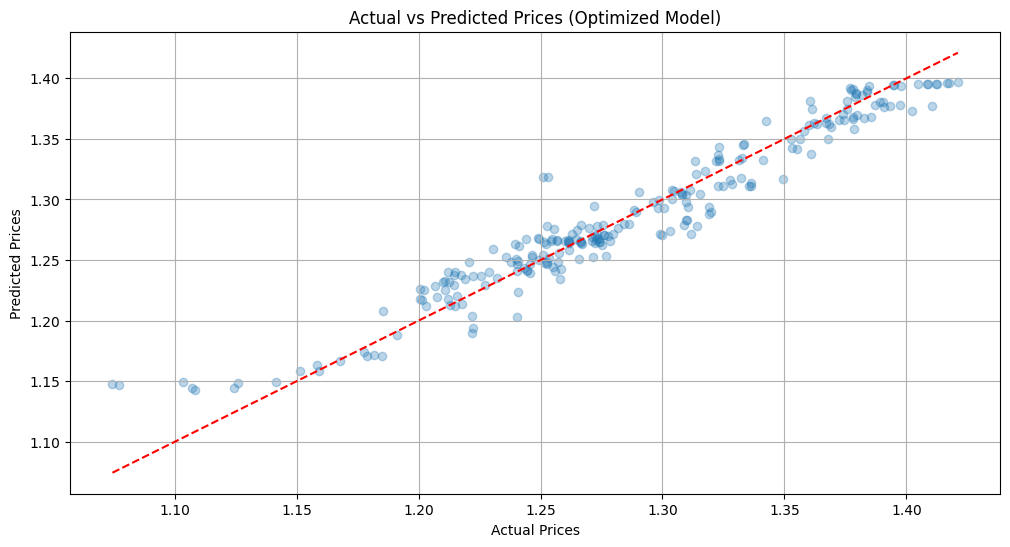

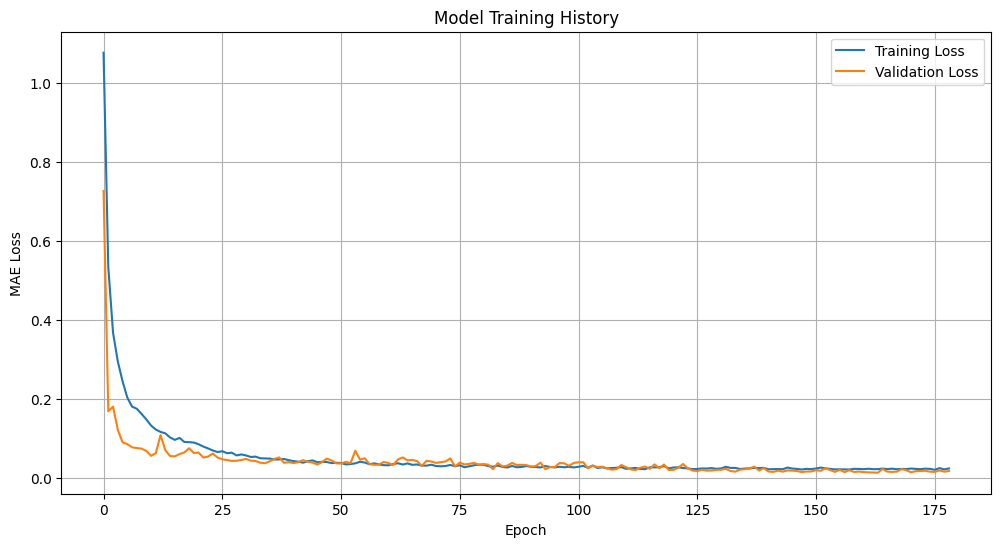


Example predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/06/2024: 1.2696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
01/01/2025: 1.2406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


31/12/2025: 1.2811

Model saved as 'gbpusd_price_predictor.h5'


In [65]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and prepare data
data = pd.read_csv("./training_data/GBPUSD_open_5year.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Feature engineering
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['DayOfYear'] = data['Date'].dt.dayofyear
data['WeekOfYear'] = data['Date'].dt.isocalendar().week

# Target variable
prices = data['Open'].values

# Feature selection
features = ['Day', 'Month', 'Year', 'DayOfWeek', 'DayOfYear', 'WeekOfYear']
X = data[features].values
y = prices

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Hyperparameter tuning setup
def build_model(hp):
    model = keras.Sequential()
    
    # Tune number of layers
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation=hp.Choice(f'act_{i}', ['relu', 'tanh', 'elu'])))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(
            hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(keras.layers.Dense(1))
    
    # Tune learning rate
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae']
    )
    return model

# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=50,
    factor=3,
    directory='tuning',
    project_name='gbpusd_prediction'
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True,
    monitor='val_mae'
)

# Perform hyperparameter search
print("Starting hyperparameter search...")
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal hyperparameters:
- Number of layers: {best_hps.get('num_layers')}
- Learning rate: {best_hps.get('lr'):.5f}
""")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"\nTest MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R2: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Optimized Model)')
plt.grid(True)
plt.show()

# Training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prediction function
def predict_price(date_str):
    date = pd.to_datetime(date_str, format='%d/%m/%Y')
    features = np.array([
        date.day,
        date.month,
        date.year,
        date.dayofweek,
        date.dayofyear,
        date.isocalendar().week
    ]).reshape(1, -1)
    features_scaled = scaler.transform(features)
    return model.predict(features_scaled)[0][0]

# Example predictions
print("\nExample predictions:")
print(f"15/06/2024: {predict_price('15/06/2024'):.4f}")
print(f"01/01/2025: {predict_price('01/01/2025'):.4f}")
print(f"31/12/2025: {predict_price('31/12/2025'):.4f}")

# Save model
model.save('gbpusd_price_predictor.h5')
print("\nModel saved as 'gbpusd_price_predictor.h5'")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step

First 20 predictions:
      Date  Actual_Price  Predicted_Price
2020-04-09        1.2470         1.285857
2020-04-14        1.2594         1.287445
2020-04-15        1.2498         1.285706
2020-04-16        1.2451         1.284003
2020-04-17        1.2504         1.282466
2020-04-20        1.2473         1.287200
2020-04-21        1.2273         1.285585
2020-04-22        1.2329         1.283918
2020-04-23        1.2386         1.282268
2020-04-24        1.2338         1.280852
2020-04-27        1.2409         1.285306
2020-04-28        1.2436         1.283733
2020-04-29        1.2436         1.282173
2020-04-30        1.2613         1.280689
2020-05-01        1.2547         1.280699
2020-05-04        1.2421         1.286289
2020-05-05        1.2454         1.283537
2020-05-06        1.2362         1.281956
2020-05-07        1.2287         1.280367
2020-05-11        1.2358         1.283365

Last 20 predictions:
      Date  Actual_Price  Predic

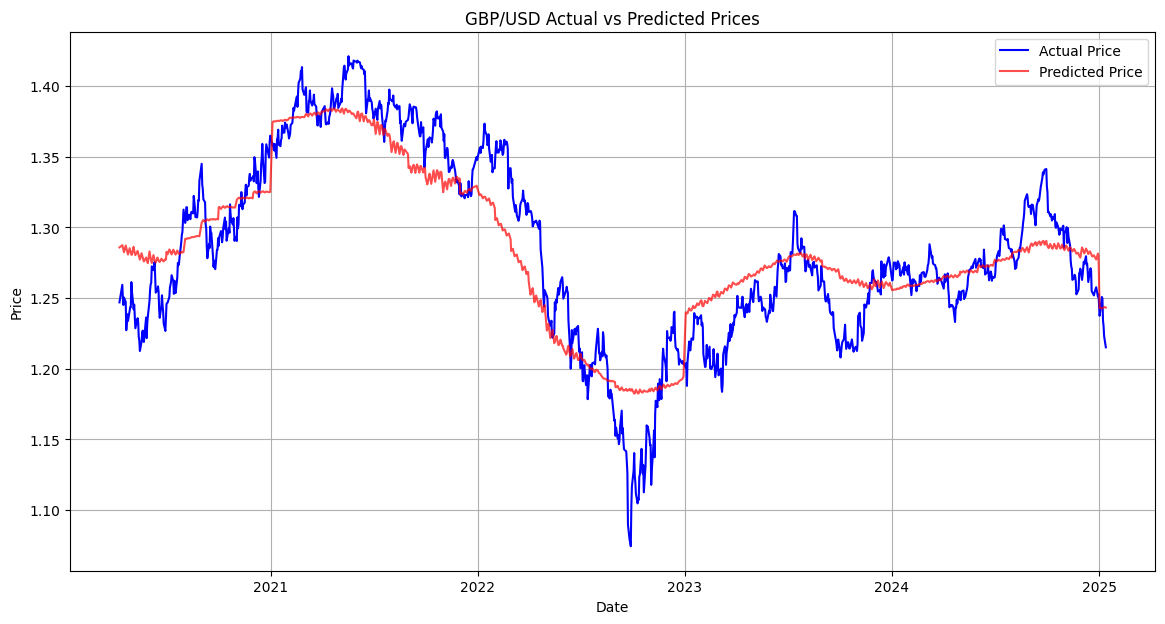

In [63]:
all_predictions = model.predict(X_scaled).flatten()
# Create results DataFrame
results = pd.DataFrame({
    'Date': data['Date'],
    'Actual_Price': data['Open'],
    'Predicted_Price': all_predictions
})

# Print first 20 and last 20 rows
print("\nFirst 20 predictions:")
print(results.head(20).to_string(index=False))

print("\nLast 20 predictions:")
print(results.tail(20).to_string(index=False))

# Save to CSV
results.to_csv('price_predictions.csv', index=False)
print("\nPredictions saved to 'price_predictions.csv'")

# Plot actual vs predicted for the entire dataset
plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual_Price'], label='Actual Price', color='blue')
plt.plot(results['Date'], results['Predicted_Price'], label='Predicted Price', color='red', alpha=0.7)
plt.title('GBP/USD Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step

Last 20 historical predictions:
      Date       Type  Actual_Price  Predicted_Price
2024-12-12 Historical        1.2690         1.282342
2024-12-13 Historical        1.2614         1.281180
2024-12-16 Historical        1.2691         1.283092
2024-12-17 Historical        1.2711         1.282142
2024-12-18 Historical        1.2693         1.281199
2024-12-19 Historical        1.2551         1.280334
2024-12-20 Historical        1.2541         1.279438
2024-12-23 Historical        1.2519         1.280332
2024-12-24 Historical        1.2539         1.279448
2024-12-27 Historical        1.2577         1.277283
2024-12-30 Historical        1.2511         1.281530
2024-12-31 Historical        1.2529         1.280130
2025-01-02 Historical        1.2375         1.242868
2025-01-03 Historical        1.2404         1.243225
2025-01-06 Historical        1.2508         1.242793
2025-01-07 Historical        1.2498  

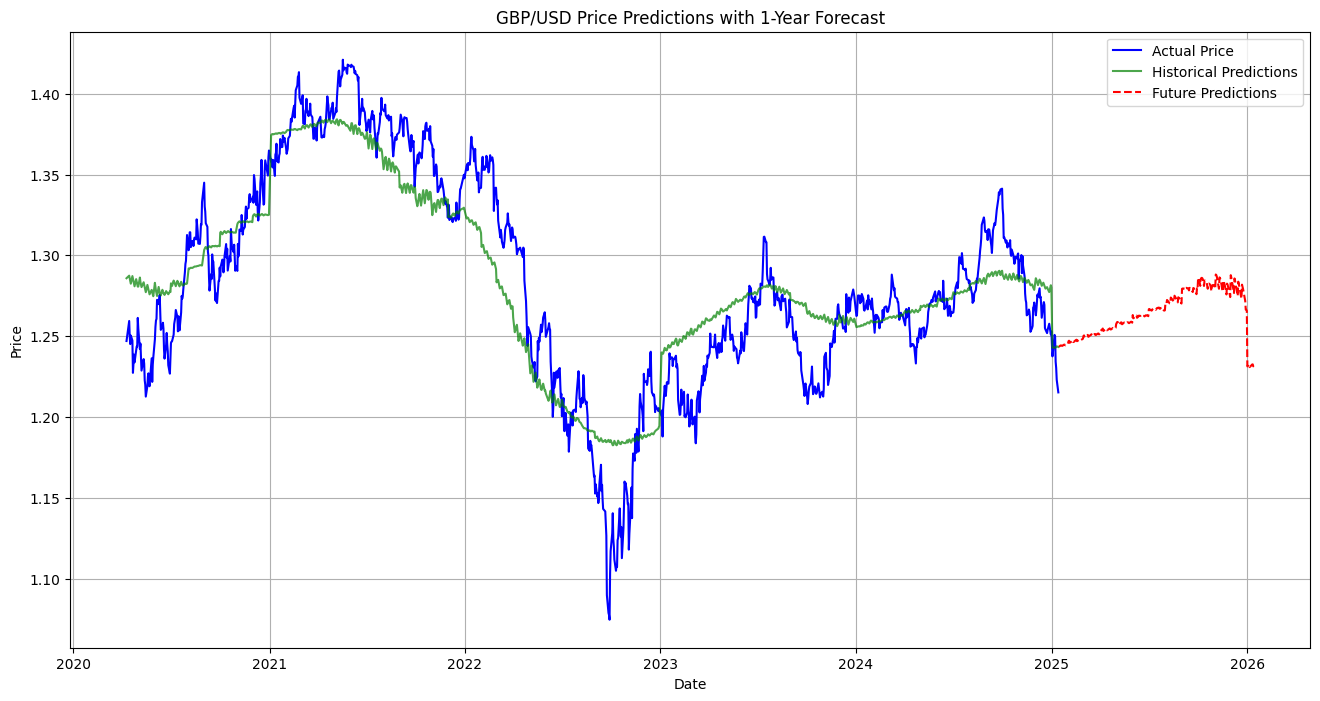

In [64]:
from datetime import datetime, timedelta
# Predict on historical data
historical_predictions = model.predict(X_scaled).flatten()

# Create future dates (1 year beyond last date in dataset)
last_date = data['Date'].max()
future_dates = [last_date + timedelta(days=x) for x in range(1, 366)]  # 1 year of future dates

# Prepare future features
future_data = pd.DataFrame({'Date': future_dates})
future_data['Day'] = future_data['Date'].dt.day
future_data['Month'] = future_data['Date'].dt.month
future_data['Year'] = future_data['Date'].dt.year
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
future_data['DayOfYear'] = future_data['Date'].dt.dayofyear
future_data['WeekOfYear'] = future_data['Date'].dt.isocalendar().week

X_future = future_data[features].values
X_future_scaled = scaler.transform(X_future)

# Predict future prices
future_predictions = model.predict(X_future_scaled).flatten()

# Combine historical and future predictions
historical_results = pd.DataFrame({
    'Date': data['Date'],
    'Type': 'Historical',
    'Actual_Price': data['Open'],
    'Predicted_Price': historical_predictions
})

future_results = pd.DataFrame({
    'Date': future_dates,
    'Type': 'Future',
    'Actual_Price': np.nan,
    'Predicted_Price': future_predictions
})

all_results = pd.concat([historical_results, future_results])

# Print and save results
print("\nLast 20 historical predictions:")
print(historical_results.tail(20).to_string(index=False))

print("\nFirst 20 future predictions:")
print(future_results.head(20).to_string(index=False))

all_results.to_csv('all_price_predictions.csv', index=False)
print("\nAll predictions saved to 'all_price_predictions.csv'")

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(historical_results['Date'], historical_results['Actual_Price'], 
         label='Actual Price', color='blue')
plt.plot(historical_results['Date'], historical_results['Predicted_Price'], 
         label='Historical Predictions', color='green', alpha=0.7)
plt.plot(future_results['Date'], future_results['Predicted_Price'], 
         label='Future Predictions', color='red', linestyle='--')
plt.title('GBP/USD Price Predictions with 1-Year Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()